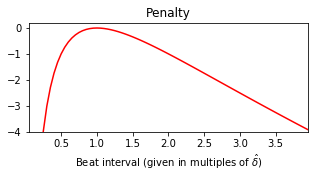

In [1]:
import numpy as np
import os, sys, librosa
from scipy import signal
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import IPython.display as ipd
import pandas as pd

sys.path.append('..')
import libfmp.b
import libfmp.c2
import libfmp.c6
%matplotlib inline

def compute_penalty(N, beat_ref):
    """| Compute penalty funtion used for beat tracking [FMP, Section 6.3.2]
    | Note: Concatenation of '0' because of Python indexing conventions

    Notebook: C6/C6S3_BeatTracking.ipynb

    Args:
        N (int): Length of vector representing penalty function
        beat_ref (int): Reference beat period (given in samples)

    Returns:
        penalty (np.ndarray): Penalty function
    """
    t = np.arange(1, N) / beat_ref
    penalty = -np.square(np.log2(t))
    t = np.concatenate((np.array([0]), t))
    penalty = np.concatenate((np.array([0]), penalty))
    return penalty


beat_ref = 20
N = 4 * beat_ref
penalty = compute_penalty(N, beat_ref)

plt.figure(figsize=(5, 2))
t = np.arange(0, N) / beat_ref
plt.plot(t, penalty, 'r')
plt.ylim([-4, 0.2])
plt.xlim([t[1], t[-1]])
plt.xlabel('Beat interval (given in multiples of $\hat{\delta}$)')
plt.title('Penalty')
plt.show()

In [4]:
def compute_beat_sequence(novelty, beat_ref, penalty=None, factor=1.0, return_all=False):
    """| Compute beat sequence using dynamic programming [FMP, Section 6.3.2]
    | Note: Concatenation of '0' because of Python indexing conventions

    Notebook: C6/C6S3_BeatTracking.ipynb

    Args:
        novelty (np.ndarray): Novelty function
        beat_ref (int): Reference beat period
        penalty (np.ndarray): Penalty function (Default value = None)
        factor (float): Weight parameter for adjusting the penalty (Default value = 1.0)
        return_all (bool): Return details (Default value = False)

    Returns:
        B (np.ndarray): Optimal beat sequence
        D (np.ndarray): Accumulated score
        P (np.ndarray): Maximization information
    """
    N = len(novelty)
    if penalty is None:
        penalty = compute_penalty(N, beat_ref)
    penalty = penalty * factor
    novelty = np.concatenate((np.array([0]), novelty))
    D = np.zeros(N + 1)
    P = np.zeros(N + 1, dtype=int)
    D[1] = novelty[1]
    P[1] = 0
    # forward calculation
    for n in range(2, N + 1):
        m_indices = np.arange(1, n)
        scores = D[m_indices] + penalty[n - m_indices]
        maxium = np.max(scores)
        if maxium <= 0:
            D[n] = novelty[n]
            P[n] = 0
        else:
            D[n] = novelty[n] + maxium
            P[n] = np.argmax(scores) + 1
    # backtracking
    B = np.zeros(N, dtype=int)
    k = 0
    B[k] = np.argmax(D)
    while P[B[k]] != 0:
        k = k + 1
        B[k] = P[B[k - 1]]
    B = B[0:k + 1]
    B = B[::-1]
    B = B - 1
    if return_all:
        return B, D, P
    else:
        return B


# Example from Exercise 6.12 of [Müller, FMP, Springer 2015]
nov = np.array([0.1, 0.0, 1.0, 0.0, 1.0, 0.8, 0.0, 0.2, 0.4, 1.0, 0.0])
# Manually specified penality values (in practice, we use the function "compute_penalty")
penalty = np.array([0, -2, -0.2, 1.0, 0.5, -0.1, -1, -1.5, -3, -5, -8])
factor = 1
beat = 3

B, D, P = compute_beat_sequence(nov, beat, penalty=penalty, factor=1, return_all=True)
df = pd.DataFrame([np.arange(1, len(nov) + 1), nov, D[1:], P[1:]])
df.rename(index={0: '$n$', 1: '$\Delta(n)$',
                 2: '$\mathbf{D}(n)$', 3: '$\mathbf{P}(n)$'}, inplace=True)
df.rename_axis('$n$', axis='rows')


class Formatter():
    """Cass for converting column to row format
    Notebook: C6/C6S3_BeatTracking.ipynb"""

    def __init__(self):
        self.i = 0

    def formatter(self, s):
        if self.i == 0 or self.i == 3:
            return_s = str(int(s))
        else:
            return_s = str(s)
        self.i += 1
        return return_s


ipd.display(ipd.HTML(df.to_html(formatters={i: Formatter().formatter for i in df.columns},
                                escape=False, header=False)))

print('Optimal beat sequency B:', B + 1)

$n$,1,2,3,4,5,6,7,8,9,10,11
$\Delta(n)$,0.1,0.0,1.0,0.0,1.0,0.8,0.0,0.2,0.4,1.0,0.0
$\mathbf{D}(n)$,0.1,0.0,1.0,1.1,2.0,2.8,2.1,3.2,4.2,4.3,4.2
$\mathbf{P}(n)$,0,0,0,1,2,3,4,5,6,6,8


Optimal beat sequency B: [ 3  6 10]


/home/mpk/anaconda3/envs/FMP/lib/python3.7/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


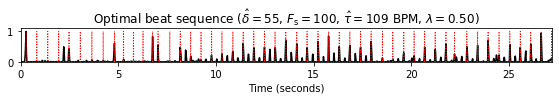

In [21]:
import soundfile as sf


def beat_period_to_tempo(beat, Fs):
    """Convert beat period (samples) to tempo (BPM) [FMP, Section 6.3.2]

    Notebook: C6/C6S3_BeatTracking.ipynb

    Args:
        beat (int): Beat period (samples)
        Fs (scalar): Sample rate

    Returns:
        tempo (float): Tempo (BPM)
    """
    tempo = 60 / (beat / Fs)
    return tempo


def compute_plot_sonify_beat(x, Fs, nov, Fs_nov, beat_ref, factor, title=None, figsize=(6, 2)):
    """Compute, plot, and sonfy beat sequence from novelty function [FMP, Section 6.3.2]

    Notebook: C6/C6S3_BeatTracking.ipynb

    Args:
        x: Novelty function
        Fs: Sample rate
        nov: Novelty function
        Fs_nov: Rate of novelty function
        beat_ref: Reference beat period
        factor: Weight parameter for adjusting the penalty
        title: Title of figure (Default value = None)
        figsize: Size of figure (Default value = (6, 2))
    """
    B = compute_beat_sequence(nov, beat_ref=beat_ref, factor=factor)

    beats = np.zeros(len(nov))
    beats[np.array(B, dtype=np.int32)] = 1
    if title is None:
        tempo = beat_period_to_tempo(beat_ref, Fs_nov)
        title = (r'Optimal beat sequence ($\hat{\delta}=%d$, $F_\mathrm{s}=%d$, '
                 r'$\hat{\tau}=%0.0f$ BPM, $\lambda=%0.2f$)' % (beat_ref, Fs_nov, tempo, factor))

    fig, ax, line = libfmp.b.plot_signal(nov, Fs_nov, color='k', title=title, figsize=figsize)
    T_coef = np.arange(nov.shape[0]) / Fs_nov
    ax.plot(T_coef, beats, ':r', linewidth=1)
    plt.show()

    beats_sec = T_coef[B]
    x_peaks = librosa.clicks(beats_sec, sr=Fs, click_freq=1000, length=len(x))
    ipd.display(ipd.Audio(x + x_peaks, rate=Fs))
    sf.write('final_countdown.wav', x + x_peaks, samplerate=Fs)


fn_wav = os.path.join('data', 'final-countdown-drums-first-20-seconds.mp3')
Fs = 22050
x, Fs = librosa.load(fn_wav, Fs)

nov, Fs_nov = libfmp.c6.compute_novelty_spectrum(x, Fs=Fs, N=2048, H=512, gamma=100, M=10, norm=True)
nov, Fs_nov = libfmp.c6.resample_signal(nov, Fs_in=Fs_nov, Fs_out=100)

# compute_plot_sonify_beat(x, Fs, nov, Fs_nov, beat_ref=25, factor=1, figsize=(8,1.5))
# compute_plot_sonify_beat(x, Fs, nov, Fs_nov, beat_ref=75, factor=0.5, figsize=(8,1.5))
compute_plot_sonify_beat(x, Fs, nov, Fs_nov, beat_ref=55, factor=0.5, figsize=(8, 1.5))